In [356]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, validation_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

# Data description and preprocessing

In [357]:
data = pd.read_csv('../dataset/mammographic_masses.data', header=None, na_values='?')
data.columns = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

print("Data shape: " , data.shape)
data.head()

Data shape:  (961, 6)


,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [358]:
data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Fix outliers and missing values

In [359]:
# Check for missing values
for i in data.columns[data.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    data[i].fillna(round(data[i].mean()),inplace=True)
data

#---Checking for Outliers
data.drop(data[data['BI-RADS'] >= 6 ].index, inplace=True)
data.drop(data[data['BI-RADS'] <= 0 ].index, inplace=True)

data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,4.297669,55.399364,2.719280,2.795551,2.916314,0.458686
std,0.612139,14.449328,1.225658,1.531411,0.366099,0.498554
min,2.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,56.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,5.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Check if data is balanced

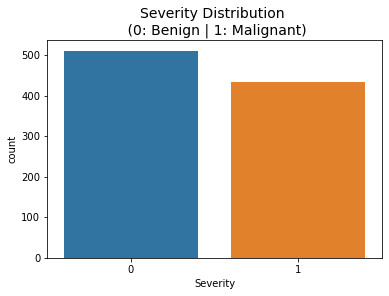

Benign:  54.13 % of the dataset
Malignant:  45.87 % of the dataset


In [360]:
sns.countplot(x='Severity', data=data)
plt.title('Severity Distribution \n (0: Benign | 1: Malignant)', fontsize=14)
plt.show()

print('Benign: ', round(data['Severity'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Malignant: ', round(data['Severity'].value_counts()[1]/len(data) * 100,2), '% of the dataset')


# Data visualization

<Figure size 1440x1440 with 0 Axes>

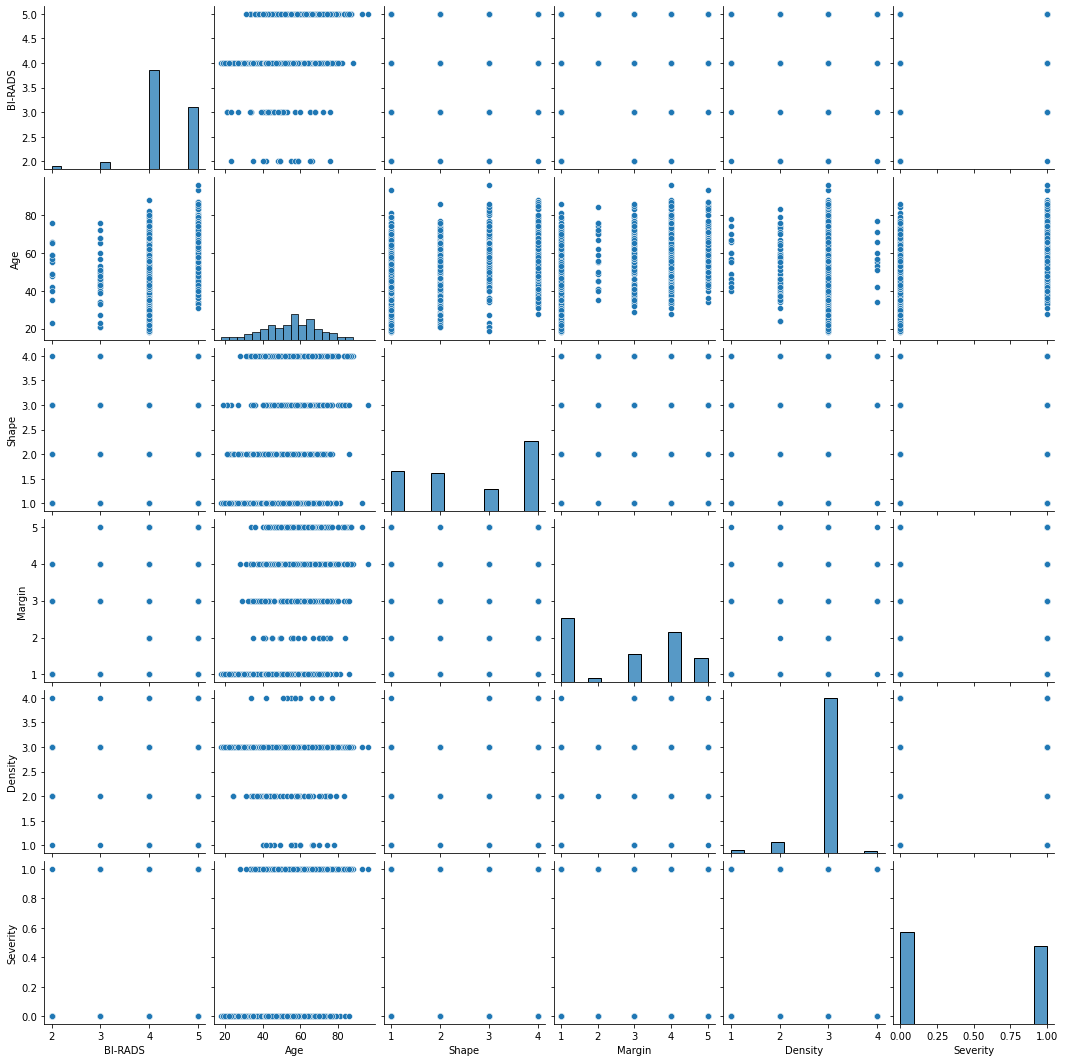

In [361]:
plt.figure(figsize=(20,20))
sns.pairplot(data)
plt.show()

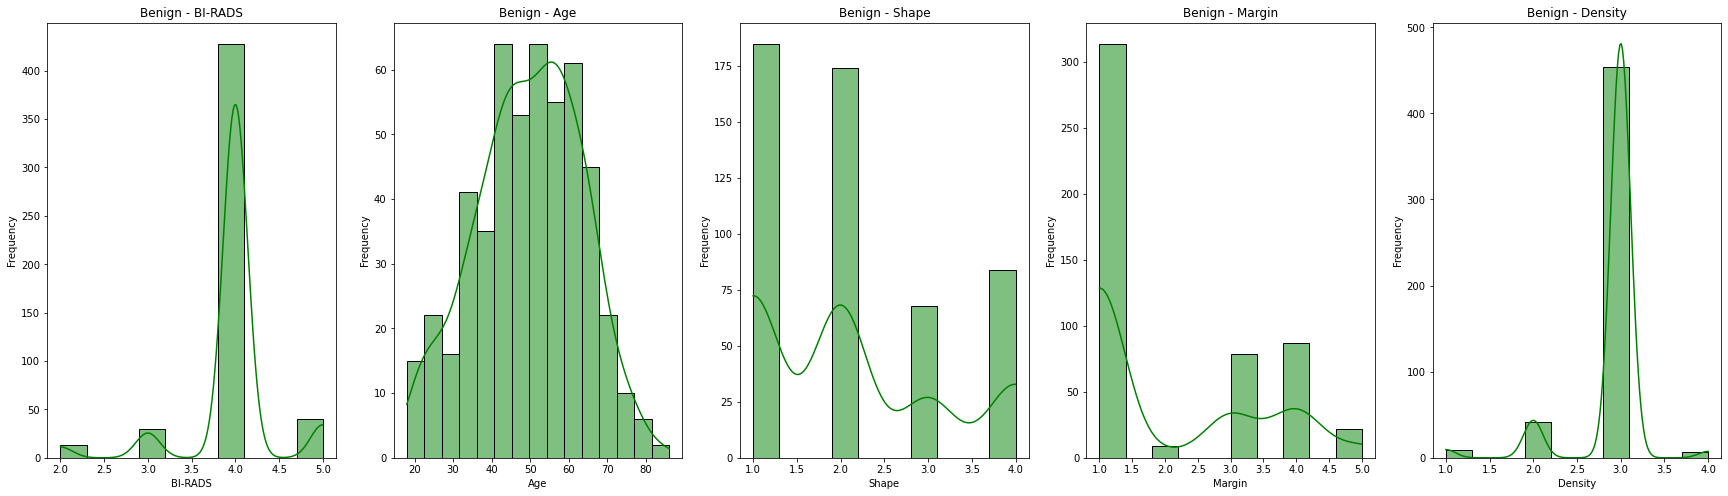

In [362]:
f, axes = plt.subplots(ncols=5, figsize=(30, 8))

for i, col in enumerate(data.columns[0:5]):
    data_benign = data[col][data.Severity == 0].values
    sns.histplot(data_benign, ax=axes[i], kde=True, color='green')
    axes[i].set_title('Benign - ' + col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

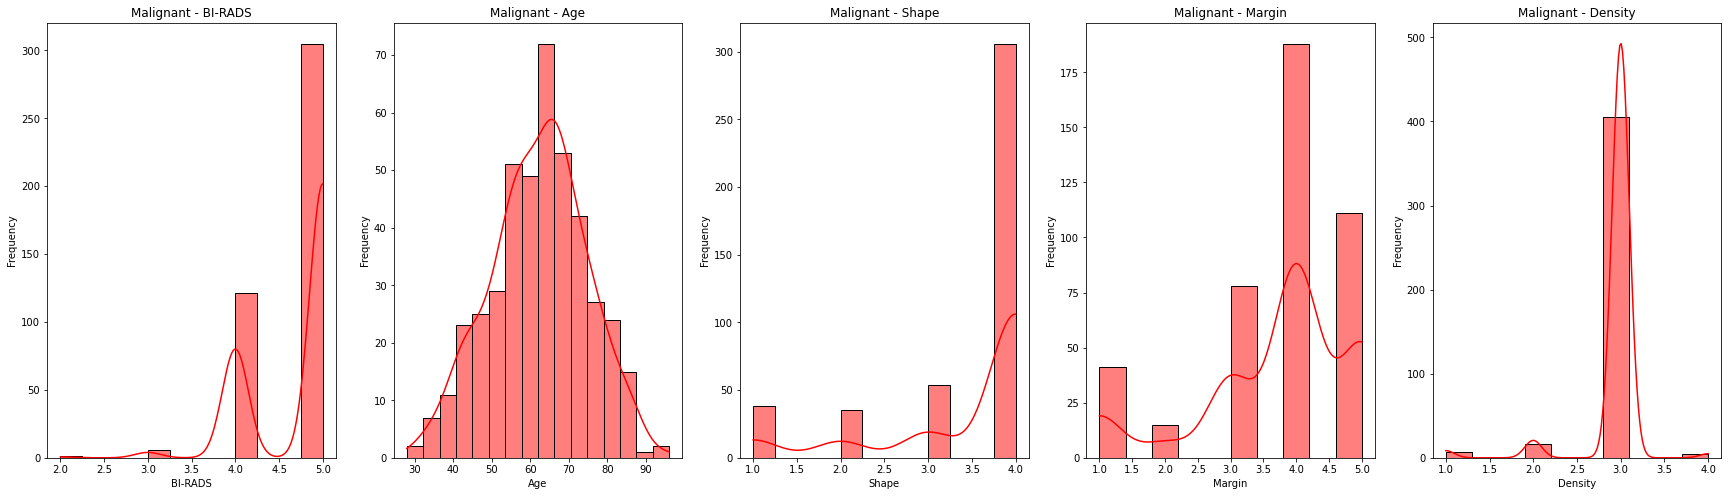

In [363]:
f, axes = plt.subplots(ncols=5, figsize=(30, 8))

for i, col in enumerate(data.columns[0:5]):
    data_malign = data[col][data.Severity == 1].values
    sns.histplot(data_malign, ax=axes[i], kde=True, color='red')
    axes[i].set_title('Malignant - ' + col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

Correlation Matrices

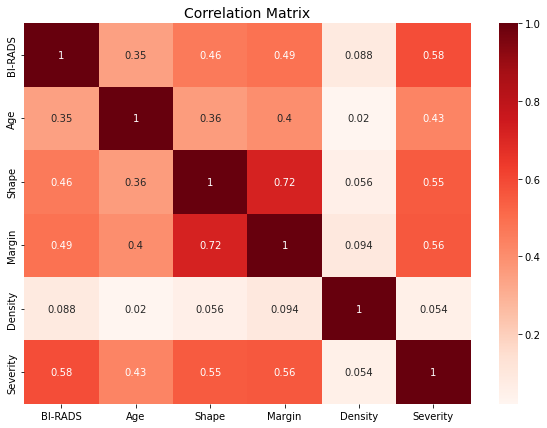

In [364]:
corr = data.corr()

plt.figure(figsize=(10, 7))

sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Box and Whisker Plot

Text(0.5, 1.0, 'Severity - Margin')

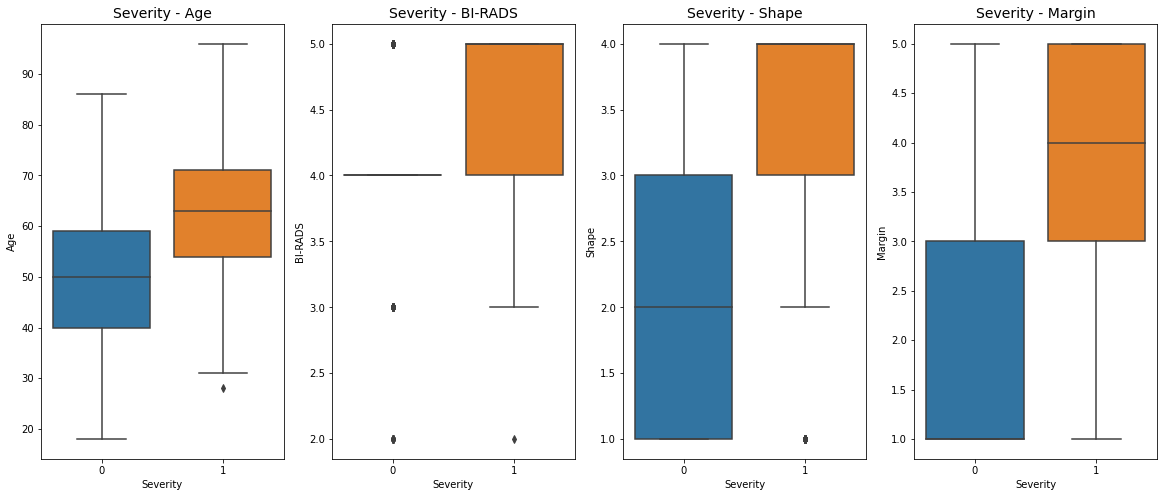

In [365]:
f, axes = plt.subplots(ncols=4, figsize=(20, 8))

sns.boxplot(x='Severity', y='Age', data=data, ax=axes[0])
axes[0].set_title('Severity - Age', fontsize=14) 

sns.boxplot(x='Severity', y='BI-RADS', data=data, ax=axes[1])
axes[1].set_title('Severity - BI-RADS', fontsize=14) 

sns.boxplot(x='Severity', y='Shape', data=data, ax=axes[2])
axes[2].set_title('Severity - Shape', fontsize=14)

sns.boxplot(x='Severity', y='Margin', data=data, ax=axes[3])
axes[3].set_title('Severity - Margin', fontsize=14) 


Standardization, Normalization

In [366]:
features_values = data.values[:, 0:5]
severity_values = data['Severity']

print(severity_values.shape)
print(features_values.shape)

severity_values = severity_values.values.reshape(-1, 1)
print(severity_values.shape)

(944,)
(944, 5)
(944, 1)


In [367]:
scaler  = StandardScaler()
features_values = scaler.fit_transform(features_values)
features_values

array([[ 1.1479474 ,  0.80327507,  0.22915791,  1.44025222,  0.22871089],
       [-0.48653578, -0.8585823 , -1.40348413, -1.17310309,  0.22871089],
       [ 1.1479474 ,  0.18007856,  1.04547894,  1.44025222,  0.22871089],
       ...,
       [-0.48653578,  0.5955429 ,  1.04547894,  1.44025222,  0.22871089],
       [ 1.1479474 ,  0.73403102,  1.04547894,  1.44025222,  0.22871089],
       [-0.48653578,  0.45705479,  0.22915791,  0.13357457,  0.22871089]])

# Model

Model training

In [368]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features_values, severity_values, test_size=0.2, random_state=0)

In [369]:
# codigo para ver qual os atributos mais importantes (atraves do RFECV)a partir de um determinado parametro escolhido por nos neste caso "accuracy"
#from sklearn.feature_selection import RFECV
#from sklearn.tree import DecisionTreeClassifier
#model = DecisionTreeClassifier()
#rfecv = RFECV(estimator= model, step = 1, cv = 5, scoring="accuracy")
#rfecv = rfecv.fit(X_train, y_train)

#print("The optimal number of features:", rfecv.n_features_)
#print("The best features:", rfecv.support_)
#print("Best features:", X_train.columns[rfecv.support_])

In [370]:
regressor = RandomForestRegressor()

n = 3
rfe = RFE(estimator=regressor, n_features_to_select=n)  
rfe.fit(X_train, np.ravel(y_train))

print("Suport: ", rfe.support_)
print("Ranking: ", rfe.ranking_)
print("Feature importance: ", rfe.estimator_.feature_importances_)

print(sum(rfe.estimator_.feature_importances_))


Suport:  [ True  True  True False False]
Ranking:  [1 1 1 2 3]
Feature importance:  [0.52460676 0.31839124 0.15700201]
1.0


[0.47793309 0.20428476 0.14338172]
0.8255995653838517


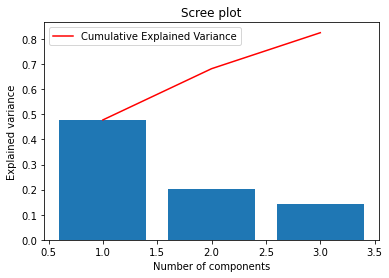

In [371]:
pca = PCA(n_components=3)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(pca.explained_variance_ratio_)

print(sum(pca.explained_variance_ratio_))

plt.bar(
    range(1,len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_ratio_
    )

plt.plot(
    range(1,len(pca.explained_variance_ratio_ )+1),
    np.cumsum(pca.explained_variance_ratio_),
    c='red',
    label='Cumulative Explained Variance')

plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Scree plot')
plt.show()

Model  training, Model hyper-parameter selection, onfusion Matrix

In [372]:
def train(model, X_train, X_test, y_train, y_test ):
    print("Training Model: ", model.__class__.__name__)
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)
    test_data_acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    print("Accuracy: ", test_data_acc)
    print("F1 Score: ", f1)
    print("True Positive Rate: ", tpr)
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: ")
    print(cm)
        
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # ROC Curve
    plt.plot(fpr, tpr, color='orange', label='ROC (AUC = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    print("Classification Report:")
    print(classification_report(y_test, model.predict(X_test)))
    
def hyper_parameter(hypertuned_model, parameters, X_train, y_train):
    print("Hyper Parameter Tuning for :", hypertuned_model.__class__.__name__)
    model = GridSearchCV(hypertuned_model, parameters, scoring="accuracy")
    model.fit(X_train, np.ravel(y_train))
    print(" Best Params: ", model.best_params_)
    return model.best_params_

def k_fold_cross_validation(model, k , X_train, y_train):
    print("K-Fold Cross Validation for :", model.__class__.__name__)
    kfold = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="accuracy", cv=k, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]

def validationCurve(parameter_list, parameter_name, X_train, y_train, model):
    print("Validation Curve for :", model.__class__.__name__)
    train_scores, valid_scores = validation_curve(model, X_train, np.ravel(y_train), param_name = parameter_name, param_range = parameter_list, cv=5, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)

    plt.plot(parameter_list, train_scores_mean, label = "Train", color = 'b')
    plt.plot(parameter_list, test_scores_mean, label = "Cross Validation", color = 'r')
    plt.title("Validation Curve")
    plt.xlabel(parameter_name)
    plt.ylabel("Score")
    plt.legend()
    plt.show()


## Logistic Regression

Logistic Regression - Base Model
Training Model:  LogisticRegression
Accuracy:  0.873015873015873
F1 Score:  0.8536585365853657
True Positive Rate:  [0.         0.84337349 1.        ]
Confusion Matrix: 
[[95 11]
 [13 70]]


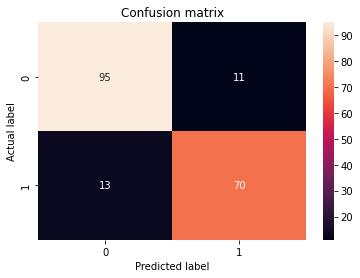

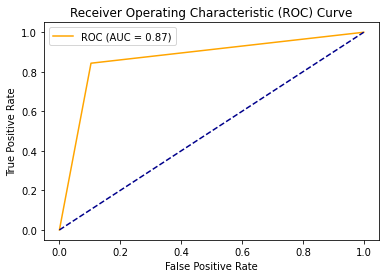

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       106
           1       0.86      0.84      0.85        83

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

Hyper Parameter Tuning for : LogisticRegression
 Best Params:  {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Training Model:  LogisticRegression
Accuracy:  0.8624338624338624
F1 Score:  0.8488372093023256
True Positive Rate:  [0.         0.87951807 1.        ]
Confusion Matrix: 
[[90 16]
 [10 73]]


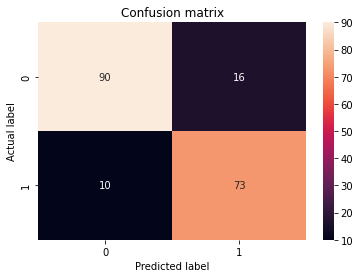

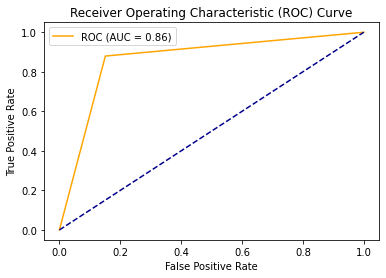

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       106
           1       0.82      0.88      0.85        83

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189

#############################

K-Fold Cross Validation for : LogisticRegression
Training Model:  LogisticRegression
Accuracy:  0.8624338624338624
F1 Score:  0.8488372093023256
True Positive Rate:  [0.         0.87951807 1.        ]
Confusion Matrix: 
[[90 16]
 [10 73]]


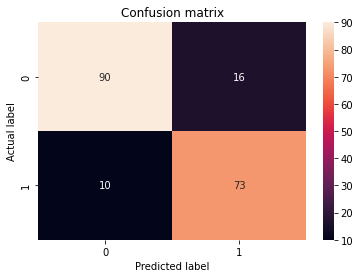

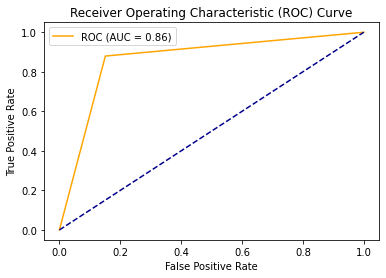

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       106
           1       0.82      0.88      0.85        83

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189

#############################

Validation Curve for : LogisticRegression


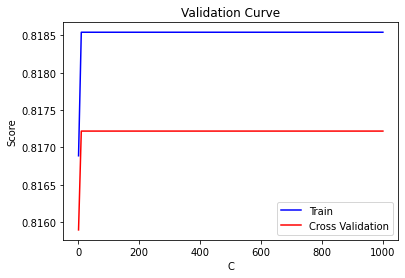

In [373]:
logisticRegression = LogisticRegression()

print("Logistic Regression - Base Model")
train(logisticRegression, X_train, X_test, y_train, y_test)

print('#############################\n')

logisticRegressionHyperTuned = LogisticRegression()
parameters =  [{'solver': ['liblinear'], 'max_iter': [100, 500, 700], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'], 'penalty': ['l1', 'l2']}]
best_parameters = hyper_parameter(logisticRegressionHyperTuned, parameters, X_train, y_train)

logisticRegressionHyperTuned.set_params(**best_parameters)
train(logisticRegressionHyperTuned, X_train, X_test, y_train, y_test)

print('#############################\n')

logisticRegressionKfmodel = k_fold_cross_validation(logisticRegressionHyperTuned, 5, X_train, y_train)
train(logisticRegressionKfmodel, X_train, X_test, y_train, y_test)

print('#############################\n')

validationCurve(np.array([1, 10, 100, 500, 1000]), "C", X_train, y_train, logisticRegressionKfmodel)

## Neural Network

Training Model:  MLPClassifier
Accuracy:  0.873015873015873
F1 Score:  0.8518518518518519
True Positive Rate:  [0.        0.8313253 1.       ]
Confusion Matrix: 
[[96 10]
 [14 69]]


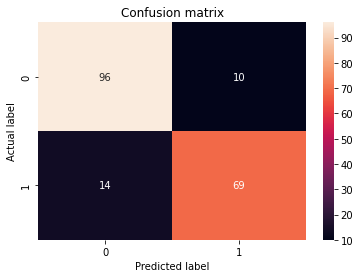

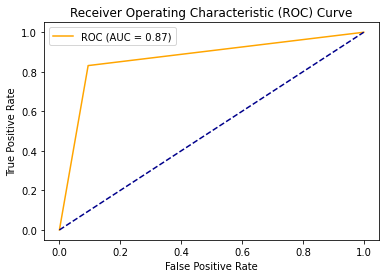

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       106
           1       0.87      0.83      0.85        83

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

Hyper Parameter Tuning for : MLPClassifier
 Best Params:  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (12, 12), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}
Training Model:  MLPClassifier
Accuracy:  0.8677248677248677
F1 Score:  0.8484848484848484
True Positive Rate:  [0.         0.84337349 1.        ]
Confusion Matrix: 
[[94 12]
 [13 70]]


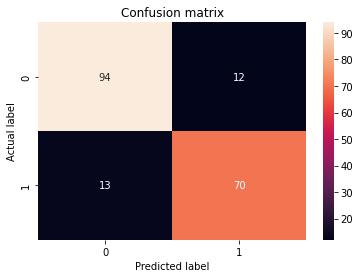

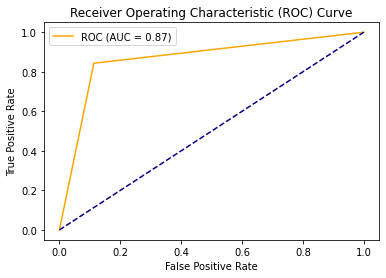

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       106
           1       0.85      0.84      0.85        83

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

K-Fold Cross Validation for : MLPClassifier
Training Model:  MLPClassifier
Accuracy:  0.8677248677248677
F1 Score:  0.8484848484848484
True Positive Rate:  [0.         0.84337349 1.        ]
Confusion Matrix: 
[[94 12]
 [13 70]]


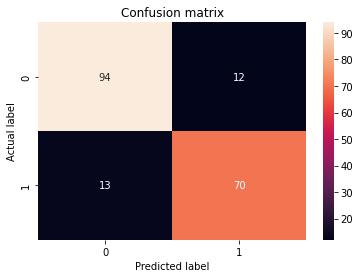

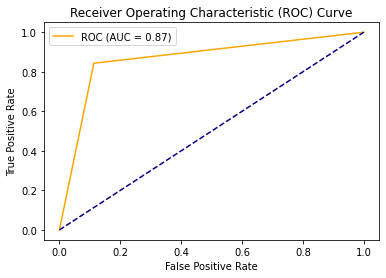

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       106
           1       0.85      0.84      0.85        83

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

Validation Curve for : MLPClassifier


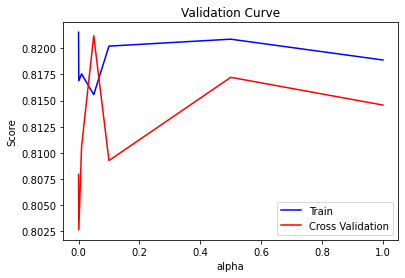

In [378]:
mlpClassifier = MLPClassifier(max_iter=5000)
train(mlpClassifier, X_train, X_test, y_train, y_test)

print('#############################\n')

mlpClassifierHyperTuned = MLPClassifier()
parameters = [{'solver': ['adam'], 'max_iter': [1000], 'hidden_layer_sizes': [(12,12), (12,12,12)], 'activation': ['tanh', 'relu'], 'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1], 'learning_rate': ['constant', 'invscaling'], 'learning_rate_init': [0.001, 0.01]}]
best_parameters = hyper_parameter(mlpClassifierHyperTuned, parameters, X_train, y_train)

mlpClassifierHyperTuned.set_params(**best_parameters)
train(mlpClassifierHyperTuned, X_train, X_test, y_train, y_test)

print('#############################\n')
mlpClassifierKfmodel = k_fold_cross_validation(mlpClassifierHyperTuned, 5, X_train, y_train)
train(mlpClassifierKfmodel, X_train, X_test, y_train, y_test)

print('#############################\n')

validationCurve(np.array([0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1]), "alpha", X_train, y_train, mlpClassifierKfmodel)

## SVM

Training Model:  SVC
Accuracy:  0.8677248677248677
F1 Score:  0.8466257668711658
True Positive Rate:  [0.        0.8313253 1.       ]
Confusion Matrix: 
[[95 11]
 [14 69]]


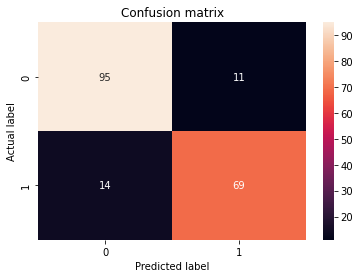

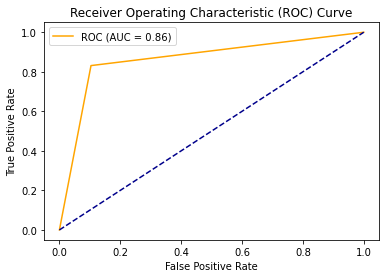

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       106
           1       0.86      0.83      0.85        83

    accuracy                           0.87       189
   macro avg       0.87      0.86      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

Hyper Parameter Tuning for : SVC
 Best Params:  {'C': 50, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf'}
Training Model:  SVC
Accuracy:  0.8624338624338624
F1 Score:  0.8488372093023256
True Positive Rate:  [0.         0.87951807 1.        ]
Confusion Matrix: 
[[90 16]
 [10 73]]


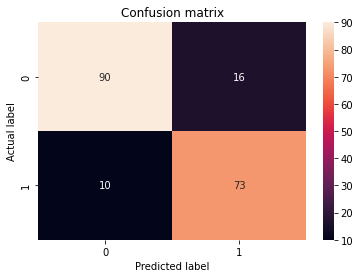

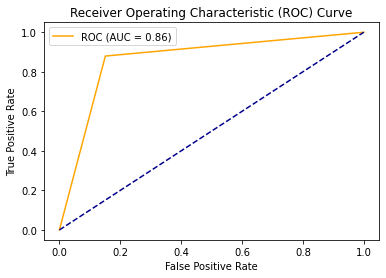

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       106
           1       0.82      0.88      0.85        83

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189

#############################

K-Fold Cross Validation for : SVC
Training Model:  SVC
Accuracy:  0.8624338624338624
F1 Score:  0.8488372093023256
True Positive Rate:  [0.         0.87951807 1.        ]
Confusion Matrix: 
[[90 16]
 [10 73]]


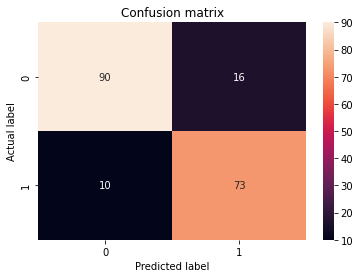

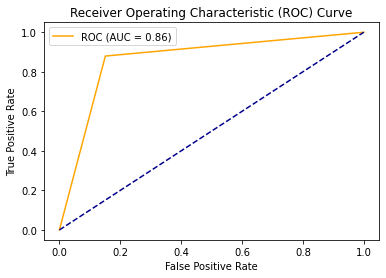

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       106
           1       0.82      0.88      0.85        83

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189

#############################

Validation Curve for : SVC


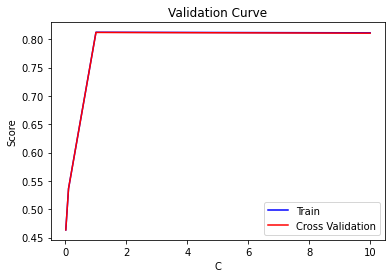

Validation Curve for : SVC


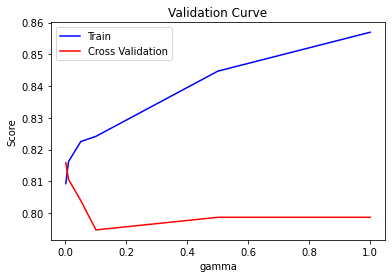

In [375]:
svc = SVC()
train(svc, X_train, X_test, y_train, y_test)

print('#############################\n')

svcHyperTuned = SVC()
#parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1], 'C': [0.01, 0.1, 1, 10, 50, 75, 100, 250, 500, 750, 1000]}]
parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1], 'C': [0.01, 0.1, 1, 10, 50, 75, 100, 250, 500, 750, 1000], 'class_weight': ['balanced']}]
best_svc_parameters = hyper_parameter(svcHyperTuned, parameters, X_train, y_train)

svcHyperTuned.set_params(**best_svc_parameters)
train(svcHyperTuned, X_train, X_test, y_train, y_test)

print('#############################\n')

mlpClassifierKfmodel = k_fold_cross_validation(svcHyperTuned, 5, X_train, y_train)
train(mlpClassifierKfmodel, X_train, X_test, y_train, y_test)

print('#############################\n')

validationCurve(np.array([0.01, 0.1, 1, 10]), "C", X_train, y_train, mlpClassifierKfmodel)
validationCurve(np.array([0.001, 0.01, 0.05, 0.1, 0.5, 1]), "gamma", X_train, y_train, mlpClassifierKfmodel)

## k-Nearest Neighbor (k-NN) classifier

KNN - Base Model
Training Model:  KNeighborsClassifier
Accuracy:  0.8253968253968254
F1 Score:  0.8070175438596491
True Positive Rate:  [0.        0.8313253 1.       ]
Confusion Matrix: 
[[87 19]
 [14 69]]


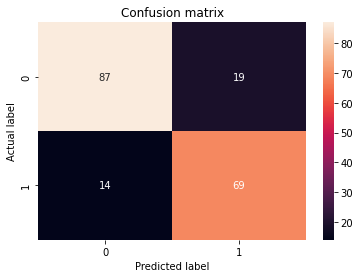

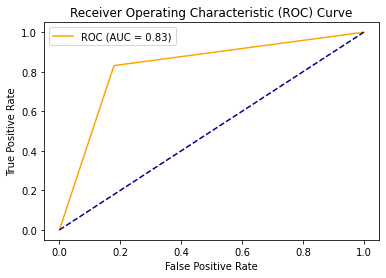

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       106
           1       0.78      0.83      0.81        83

    accuracy                           0.83       189
   macro avg       0.82      0.83      0.82       189
weighted avg       0.83      0.83      0.83       189

#############################

Hyper Parameter Tuning for : KNeighborsClassifier
 Best Params:  {'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'uniform'}
Training Model:  KNeighborsClassifier
Accuracy:  0.873015873015873
F1 Score:  0.8588235294117647
True Positive Rate:  [0.         0.87951807 1.        ]
Confusion Matrix: 
[[92 14]
 [10 73]]


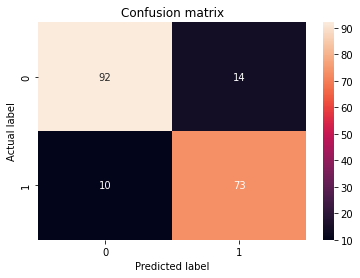

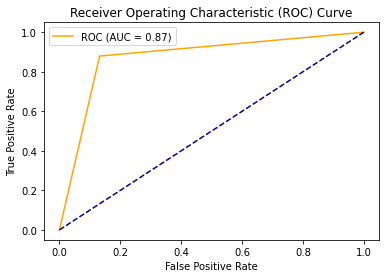

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       106
           1       0.84      0.88      0.86        83

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

K-Fold Cross Validation for : KNeighborsClassifier
Training Model:  KNeighborsClassifier
Accuracy:  0.873015873015873
F1 Score:  0.8588235294117647
True Positive Rate:  [0.         0.87951807 1.        ]
Confusion Matrix: 
[[92 14]
 [10 73]]


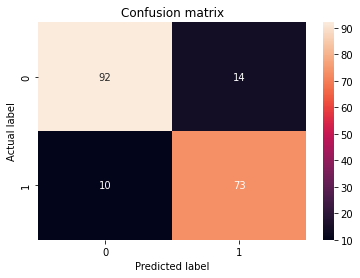

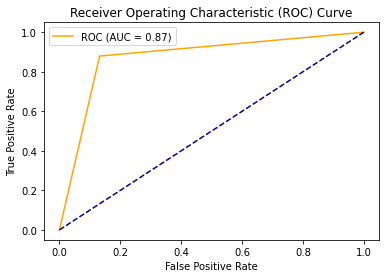

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       106
           1       0.84      0.88      0.86        83

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

Validation Curve for : KNeighborsClassifier


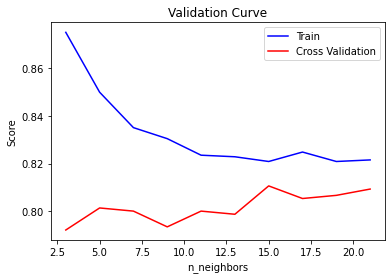

In [376]:
knn = KNeighborsClassifier()

print("KNN - Base Model")
train(knn, X_train, X_test, y_train, y_test)

print('#############################\n')

knnHyperTuned = KNeighborsClassifier()
parameters = [{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
best_parameters = hyper_parameter(knnHyperTuned, parameters, X_train, y_train)

knnHyperTuned.set_params(**best_parameters)
train(knnHyperTuned, X_train, X_test, y_train, y_test)

print('#############################\n')

knnKfmodel = k_fold_cross_validation(knnHyperTuned, 5, X_train, y_train)
train(knnKfmodel, X_train, X_test, y_train, y_test)

print('#############################\n')

validationCurve(np.array([3, 5, 7, 9, 11, 13, 15, 17, 19, 21]), "n_neighbors", X_train, y_train, knnKfmodel)

## Decision Tree

Decision Tree Classifier - Base Model
Training Model:  DecisionTreeClassifier
Accuracy:  0.7936507936507936
F1 Score:  0.7607361963190183
True Positive Rate:  [0.         0.74698795 1.        ]
Confusion Matrix: 
[[88 18]
 [21 62]]


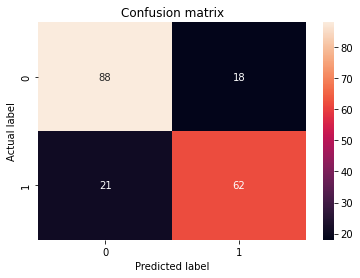

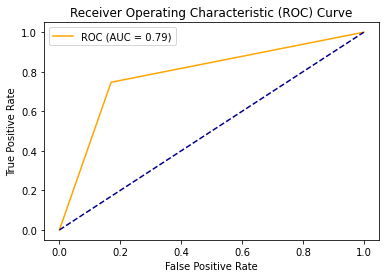

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       106
           1       0.78      0.75      0.76        83

    accuracy                           0.79       189
   macro avg       0.79      0.79      0.79       189
weighted avg       0.79      0.79      0.79       189

#############################

Hyper Parameter Tuning for : DecisionTreeClassifier
 Best Params:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 9, 'splitter': 'random'}
Training Model:  DecisionTreeClassifier
Accuracy:  0.8465608465608465
F1 Score:  0.8129032258064516
True Positive Rate:  [0.         0.75903614 1.        ]
Confusion Matrix: 
[[97  9]
 [20 63]]


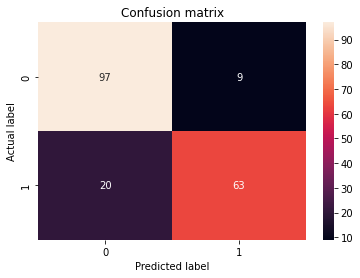

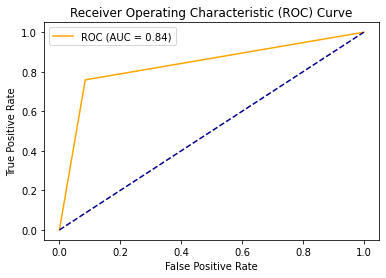

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       106
           1       0.88      0.76      0.81        83

    accuracy                           0.85       189
   macro avg       0.85      0.84      0.84       189
weighted avg       0.85      0.85      0.84       189

#############################

K-Fold Cross Validation for : DecisionTreeClassifier
Training Model:  DecisionTreeClassifier
Accuracy:  0.8412698412698413
F1 Score:  0.8314606741573033
True Positive Rate:  [0.         0.89156627 1.        ]
Confusion Matrix: 
[[85 21]
 [ 9 74]]


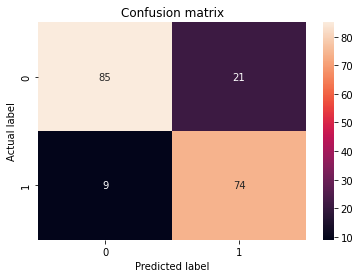

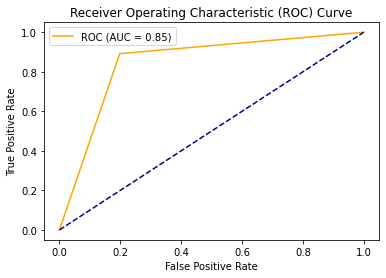

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       106
           1       0.78      0.89      0.83        83

    accuracy                           0.84       189
   macro avg       0.84      0.85      0.84       189
weighted avg       0.85      0.84      0.84       189

#############################

Validation Curve for : DecisionTreeClassifier


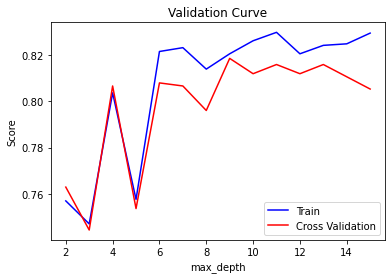

Validation Curve for : DecisionTreeClassifier


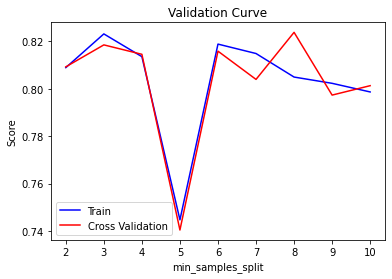

Validation Curve for : DecisionTreeClassifier


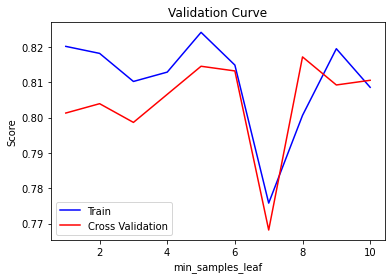

In [377]:
dtc = DecisionTreeClassifier()

print("Decision Tree Classifier - Base Model")
train(dtc, X_train, X_test, y_train, y_test)

print('#############################\n')

dtcHyperTuned = DecisionTreeClassifier()
parameters = [{'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
best_parameters = hyper_parameter(dtcHyperTuned, parameters, X_train, y_train)

dtcHyperTuned.set_params(**best_parameters)
train(dtcHyperTuned, X_train, X_test, y_train, y_test)

print('#############################\n')

dtcKfmodel = k_fold_cross_validation(dtcHyperTuned, 5, X_train, y_train)
train(dtcKfmodel, X_train, X_test, y_train, y_test)

print('#############################\n')

validationCurve(np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]), "max_depth", X_train, y_train, dtcKfmodel)
validationCurve(np.array([2, 3, 4, 5, 6, 7, 8, 9, 10]), "min_samples_split", X_train, y_train, dtcKfmodel)
validationCurve(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), "min_samples_leaf", X_train, y_train, dtcKfmodel)